# annotation figure

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.transforms as mtransforms
from matplotlib.patches import FancyBboxPatch
import numpy as np
import pandas as pd
import pyprojroot

import crowsetta
import evfuncs
import vak

In [2]:
# specify the custom font to use
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'arial'

In [3]:
from matplotlib.offsetbox import AnchoredOffsetbox

class AnchoredScaleBar(AnchoredOffsetbox):
    def __init__(self, transform, sizex=0, sizey=0, labelx=None, labely=None, loc=4, pad=0.1, borderpad=0.1, 
                 sep=2, prop=None, barcolor="black", barwidth=None, textprops=None,
                 **kwargs):
        """
        Draw a horizontal and/or vertical  bar with the size in data coordinate
        of the give axes. A label will be drawn underneath (center-aligned).
        - transform : the coordinate frame (typically axes.transData)
        - sizex,sizey : width of x,y bar, in data units. 0 to omit
        - labelx,labely : labels for x,y bars; None to omit
        - loc : position in containing axes
        - pad, borderpad : padding, in fraction of the legend font size (or prop)
        - sep : separation between labels and bars in points.
        - **kwargs : additional arguments passed to base class constructor
        """
        from matplotlib.patches import Rectangle
        from matplotlib.offsetbox import AuxTransformBox, VPacker, HPacker, TextArea, DrawingArea
        bars = AuxTransformBox(transform)
        if sizex:
            bars.add_artist(Rectangle((0,0), sizex, 0, ec=barcolor, lw=barwidth, fc="none"))
        if sizey:
            bars.add_artist(Rectangle((0,0), 0, sizey, ec=barcolor, lw=barwidth, fc="none"))

        if sizex and labelx:
            self.xlabel = TextArea(labelx, minimumdescent=False, textprops=textprops)
            bars = VPacker(children=[bars, self.xlabel], align="center", pad=0, sep=sep)
        if sizey and labely:
            self.ylabel = TextArea(labely, textprops=textprops)
            bars = HPacker(children=[self.ylabel, bars], align="center", pad=0, sep=sep)

        AnchoredOffsetbox.__init__(self, loc, pad=pad, borderpad=borderpad,
                                   child=bars, prop=prop, frameon=False, **kwargs)

In [4]:
"""functions for plotting annotations for vocalizations"""
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np


from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text, Annotation
from matplotlib.legend import Legend


class TextHandler(HandlerBase):
    def create_artists(self, legend, artist ,xdescent, ydescent, 
                       width, height, fontsize, trans,
                       fontweight='regular', fontname='Times New Roman',):
        tx = Text(width/2.,height/2, artist.get_text(), fontsize=fontsize,
                  ha="center", va="center", fontweight=fontweight, fontname=fontname)
        return [tx]

Legend.update_default_handler_map({Text : TextHandler()})


def plot_segments(onsets,
                  offsets,
                  y=0.5,
                  ax=None,
                  line_kwargs=None):
    """plot segments on an axis.

    Creates a collection of horizontal lines
    with the specified `onsets` and `offsets`
    all at height `y` and places them on the axes `ax`.

    Parameters
    ----------
    onsets : numpy.ndarray
        onset times of segments
    offsets : numpy.ndarray
        offset times of segments
    y : float, int
        height on y-axis at which segments should be plotted.
        Default is 0.5.
    ax : matplotlib.axes.Axes
        axes on which to plot segment. Default is None,
        in which case a new Axes instance is created
    line_kwargs : dict
        keyword arguments passed to the `LineCollection`
        that represents the segments. Default is None.
    """
    if line_kwargs is None:
        line_kwargs = {}

    if ax is None:
        fig, ax = plt.subplots
    segments = []
    for on, off in zip(onsets, offsets):
        segments.append(
            ((on, y), (off, y))
        )
    lc = LineCollection(segments, **line_kwargs, label='segment')
    ax.add_collection(lc)


def plot_labels(labels,
                t,
                t_shift_label=0.01,
                y=0.6,
                ax=None,
                text_kwargs=None):
    """plot labels on an axis.

    Parameters
    ----------
    labels : list, numpy.ndarray
    t : numpy.ndarray
        times (in seconds) at which to plot labels
    t_shift_label : float
        amount (in seconds) that labels should be shifted to the left, for centering.
        Necessary because width of text box isn't known until rendering.
    y : float, int
        height on y-axis at which segments should be plotted.
        Default is 0.5.
    ax : matplotlib.axes.Axes
        axes on which to plot segment. Default is None,
        in which case a new Axes instance is created
    text_kwargs : dict
        keyword arguments passed to the `Axes.text` method
        that plots the labels. Default is None.

    Returns
    -------
    text_list : list
        of text objections, the matplotlib.Text instances for each label
    """
    if text_kwargs is None:
        text_kwargs = {}

    if ax is None:
        fig, ax = plt.subplots

    text_list = []    
    
    for label, t_lbl in zip(labels, t):
        t_lbl -= t_shift_label
        text = ax.text(t_lbl, y, label, **text_kwargs, label='label')
        text_list.append(text)
    
    return text_list


def annotation(annot,
               t,
               tlim=None,
               y_segments=0.5,
               y_labels=0.6,
               t_shift_label=0.01,
               line_kwargs=None,
               text_kwargs=None,
               ax=None):
    """plot segments with labels, from annotation

    Parameters
    ----------
    annot : crowsetta.Annotation
        annotation that has segments to be plotted
        (the `annot.seq.segments` attribute)
    t : numpy.ndarray
        vector of centers of time bins from spectrogram
    tlim : tuple, list
        limits of time axis (tmin, tmax) (i.e., x-axis).
        Default is None, in which case entire range of t will be plotted.
    y_segments : float
        height at which segments should be plotted.
        Default is 0.5 (assumes y-limits of 0 and 1).
    y_labels : float
        height at which labels should be plotted.
        Default is 0.6 (assumes y-limits of 0 and 1).
    t_shift_label : float
        amount (in seconds) that labels should be shifted to the left, for centering.
        Necessary because width of text box isn't known until rendering.
    line_kwargs : dict
        keyword arguments for `LineCollection`.
        Passed to the function `vak.plot.annot.segments` that plots segments
        as a `LineCollection` instance. Default is None.
    text_kwargs : dict
        keyword arguments for `matplotlib.axes.Axes.text`.
        Passed to the function `vak.plot.annot.labels` that plots labels
        using Axes.text method. Default is None.
    ax : matplotlib.axes.Axes
        axes on which to plot segments.
        Default is None, in which case
        a new figure with a single axes is created
    """
    if ax is None:
        fig, ax = plt.subplots()
        ax.set_ylim(0, 1)

    segment_centers = []
    for on, off in zip(annot.seq.onsets_s, annot.seq.offsets_s):
        segment_centers.append(
            np.mean([on, off])
        )
    plot_segments(onsets=annot.seq.onsets_s,
                  offsets=annot.seq.offsets_s,
                  y=y_segments,
                  ax=ax,
                  line_kwargs=line_kwargs)

    if tlim:
        ax.set_xlim(tlim)
        tmin, tmax = tlim

        labels = []
        segment_centers_tmp = []
        for label, segment_center in zip(annot.seq.labels, segment_centers):
            if tmin < segment_center < tmax:
                labels.append(label)
                segment_centers_tmp.append(segment_center)
        segment_centers = segment_centers_tmp
    else:
        labels = annot.seq.labels

    segment_centers = np.array(segment_centers)
    plot_labels(labels=labels,
                t=segment_centers,
                t_shift_label=t_shift_label,
                y=y_labels,
                ax=ax,
                text_kwargs=text_kwargs)

In [5]:
DATA_ROOT = pyprojroot.here().joinpath('data')
FIG1_ROOT = DATA_ROOT.joinpath('fig1')
CBIN = FIG1_ROOT.joinpath('gy6or6_baseline_220312_0836.3.cbin')
NOTMAT = FIG1_ROOT.joinpath('gy6or6_baseline_220312_0836.3.cbin.not.mat')
NPZ = FIG1_ROOT.joinpath('gy6or6_baseline_220312_0836.3.cbin.spect.npz')

get amplitude, segments

In [6]:
rawsong, samp_freq = evfuncs.load_cbin(str(CBIN))
notmat_dict = evfuncs.load_notmat(str(NOTMAT))

smooth = evfuncs.smooth_data(rawsong, samp_freq)
threshold = notmat_dict['threshold']
min_syl_dur = notmat_dict['min_dur'] / 1000
min_silent_dur = notmat_dict['min_int'] / 1000
onsets, offsets = evfuncs.segment_song(smooth, samp_freq, threshold, min_syl_dur, min_silent_dur)

get spectrogram

In [7]:
spect_dict = vak.files.spect.load(NPZ)
s = spect_dict['s']
t = spect_dict['t']
f = spect_dict['f']

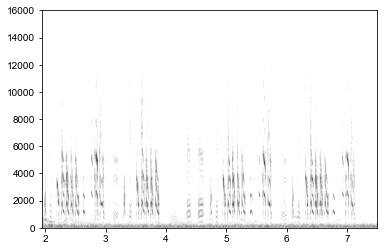

In [15]:
fig, ax = plt.subplots()

# plot spectrogram
vak.plot.spect(s_log, t, f, tlim=(1.95, 7.5), ax=ax, imshow_kwargs=IMSHOW_KWARGS)

get annotation

In [8]:
scribe = crowsetta.Transcriber(annot_format='notmat')
annot = scribe.from_file(str(NOTMAT))

In [37]:
TMIN = 3.09
TMAX = 4.1
TLIM = (TMIN, TMAX)

get amplitude trace so we can put it on plot

In [38]:
TMIN_IND, TMAX_IND = [int(t * samp_freq) for t in (TMIN, TMAX)]

log transform spectrogram and amplitude trace, and normalize amplitude trace too so it fits on annotation axes

In [39]:
s_log = np.log(s)
smooth_log_nrml = np.log10(smooth) / np.log10(smooth).max()
threshold_log_nrml = np.log10(threshold) / np.log10(smooth).max()
t_smooth = np.linspace(0, smooth_log_nrml.shape[0] * 1/samp_freq, smooth_log_nrml.shape[0])

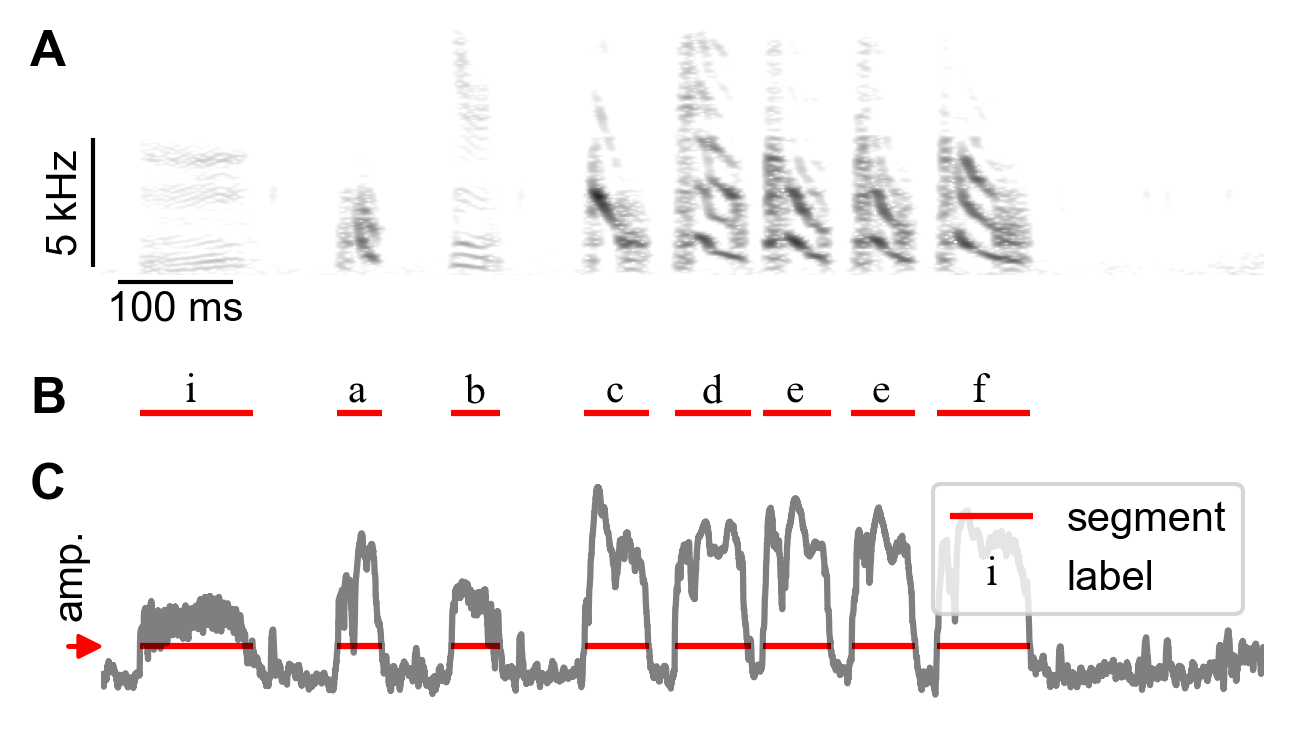

In [40]:
DPI = 300
FIGSIZE = (5, 3)

IMSHOW_KWARGS = {
    'vmin': -1,
    'vmax':12, 
    'cmap':'Greys'
}

FLIM = (500, 1e4)

fig = plt.figure(figsize=FIGSIZE, dpi=DPI)
gs = fig.add_gridspec(8, 3)
spect_ax = fig.add_subplot(gs[:3, :])
annot_ax = fig.add_subplot(gs[4:5, :])
amplitude_ax = fig.add_subplot(gs[5:8, :])

# plot spectrogram
vak.plot.spect(s_log, t, f, tlim=TLIM, flim=FLIM, ax=spect_ax, imshow_kwargs=IMSHOW_KWARGS)
x_scalebar = AnchoredScaleBar(transform=spect_ax.transData, sizex=0.1, labelx='100 ms', loc='lower right', 
                              pad=0.1,
                              barcolor='black',
                              bbox_to_anchor=(0.13,-0.25),
                              bbox_transform=spect_ax.transAxes)

spect_ax.add_artist(x_scalebar)

y_scalebar = AnchoredScaleBar(transform=spect_ax.transData, sizey=5000, labely='5 kHz', loc='lower right', 
                              pad=0.1,
                              barcolor='black',
                              bbox_to_anchor=(0.,0.),
                              bbox_transform=spect_ax.transAxes,
                              textprops={'rotation': 90})
spect_ax.add_artist(y_scalebar)

spect_ax.set_axis_off()

annotation(annot, t, y_segments=0.5, y_labels=0.65, tlim=TLIM, ax=annot_ax, line_kwargs={'color':'red'}, text_kwargs={'fontname': 'Times New Roman'})
handles, labels = annot_ax.get_legend_handles_labels()
handles += [annot_ax.texts[0]]
annot_ax.set_axis_off()

amplitude_ax.plot(t_smooth, smooth_log_nrml, alpha=0.5, color='black');
vak.plot.annot.plot_segments(onsets, offsets, y=threshold_log_nrml, ax=amplitude_ax, line_kwargs={'color':'red'})
amplitude_ax.set_xlim(TLIM)
amplitude_ax.set_ylabel('amp.', rotation=90)
amplitude_ax.yaxis.set_label_coords(-0.01,0.55)
for spine in amplitude_ax.spines.values():
    spine.set_visible(False)
amplitude_ax.set_xticks([]);
amplitude_ax.set_yticks([]);

# after drawing amplitude,
# add legend for annoations to amplitude axis, we care less about showing reader all of amplitude
amplitude_ax.legend(handles=handles, loc='upper right');

# add annotations
amplitude_ax.annotate('', xy=(TLIM[0], threshold_log_nrml), xytext=(TLIM[0]-0.03, threshold_log_nrml),
                      arrowprops=dict(width=0.1, headwidth=5, headlength=5, facecolor='red', edgecolor='red', shrink=0.05))

# add label letters to each panel
panel_labels = ['A', 'B', 'C']
ax = (spect_ax, annot_ax, amplitude_ax)
for panel_label, ax_ in zip(panel_labels, ax):
    ax_.text(-0.03, 1., panel_label, transform=ax_.transAxes,
          fontsize=12, fontweight='bold', va='top', ha='right')